In [1]:
from model import FFNet
from learning import Learn, Selector
from dataset import Dummy

from torch.optim import Adam
from torch.nn import MSELoss

<class 'dataset.Dummy'> dataset created...
epoch: 0 of 10, train loss: 25033.296244959678, val loss: 22346.774088541668
epoch: 1 of 10, train loss: 17021.72835811492, val loss: 11240.476888020834
epoch: 2 of 10, train loss: 6938.6430821572585, val loss: 2739.3585611979165
epoch: 3 of 10, train loss: 1565.052015735257, val loss: 1068.4998982747395
epoch: 4 of 10, train loss: 780.7769893523185, val loss: 841.4004923502604
epoch: 5 of 10, train loss: 753.2991953203755, val loss: 810.9225667317709
epoch: 6 of 10, train loss: 744.0702337449596, val loss: 567.0543619791666
epoch: 7 of 10, train loss: 689.0188775831654, val loss: 691.7839965820312
epoch: 8 of 10, train loss: 640.6057414393271, val loss: 911.4198608398438
epoch: 9 of 10, train loss: 569.5591755528604, val loss: 751.4378255208334
test loss: 577.5710245768229
y_pred:
tensor([[-132.4376],
        [   4.8264],
        [ -48.9601],
        [-168.9644],
        [  44.1399],
        [-240.1136],
        [-260.1850],
        [  -6.681

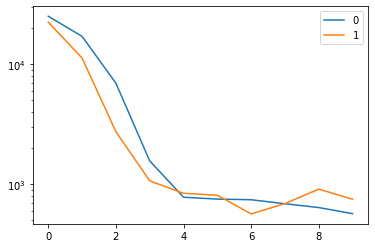

learning time: 0:00:08.566238


In [2]:
opt_params = {'lr': 0.001}
model_params = {'D_in': 128, 
                'H': 512, 
                'D_out': 1, 
                'model_name': 'funnel'}
ds_params = {'make': 'make_regression',
             'make_params': {'n_samples': 10000,
                             'n_features': 128}}
crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88}

Learn(Dummy, FFNet, Selector, Optimizer=Adam, Criterion=MSELoss, 
      model_params=model_params, ds_params=ds_params, opt_params=opt_params,
      crit_params=crit_params, sample_params=sample_params,
      save_model=False, load_model=False, load_embed=False, adapt=False,
      batch_size=256, epochs=10)